In [7]:
import pandas as pd
import numpy as np

In [8]:
property_df = pd.read_parquet("../../data/raw/property_details_w_distances.parquet")

In [9]:
columns_to_drop = ['title', 'description', 'street_address', 'suburb', 
                    'structured_features', 'video_count', 'floor_plans_count',
                   'date_listed', 'virtual_tour', 'latitude', 'longitude', 'primary_property_type']

In [10]:
target = np.array(property_df['price']) # target variable
features = np.array(property_df.drop(columns=columns_to_drop+['price']))
feature_list = list(property_df.drop(columns=columns_to_drop+['price']).columns)

In [11]:
# Taken from https://towardsdatascience.com/ai-and-real-state-renting-in-amsterdam-part-1-5fce18238dbc

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

kf = KFold(n_splits=10,random_state=30034,shuffle=True)
accuracies = []
for train_index, test_index in kf.split(features):

    data_train   = features[train_index]
    target_train = target[train_index]

    data_test    = features[test_index]
    target_test  = target[test_index]


    rf = RandomForestRegressor(n_estimators = 400, 
                                random_state = 30034, 
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                max_features = 'sqrt',
                                max_depth = None,
                                criterion = 'friedman_mse',
                                bootstrap=False)
    
    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(predictions - target_test)

    print('Mean Absolute Error:', round(np.mean(errors), 2))
    
    mape = 100 * (errors / target_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)

Mean Absolute Error: 122.56
Accuracy: 76.4 %.
Mean Absolute Error: 119.42
Accuracy: 81.85 %.
Mean Absolute Error: 172.53
Accuracy: 81.97 %.
Mean Absolute Error: 120.65
Accuracy: 58.42 %.
Mean Absolute Error: 186.98
Accuracy: 80.07 %.
Mean Absolute Error: 240.96
Accuracy: 74.27 %.
Mean Absolute Error: 119.63
Accuracy: 79.21 %.
Mean Absolute Error: 124.63
Accuracy: 82.63 %.
Mean Absolute Error: 126.57
Accuracy: 66.37 %.
Mean Absolute Error: 152.14
Accuracy: 50.03 %.
Average accuracy: 73.12040076592501


In [12]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
test_hyperparameters = False

if test_hyperparameters:
    # Use the random grid to search for best hyperparameters
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(data_train, target_train)

    print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   5.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   5.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/home/tumbles/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  20.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  16.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  16.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  16.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  14.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  14.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   0.0s
[CV] END bootstrap=True, max_depth=

/home/tumbles/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
91 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tumbles/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tumbles/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/tumbles/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/tumbles

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


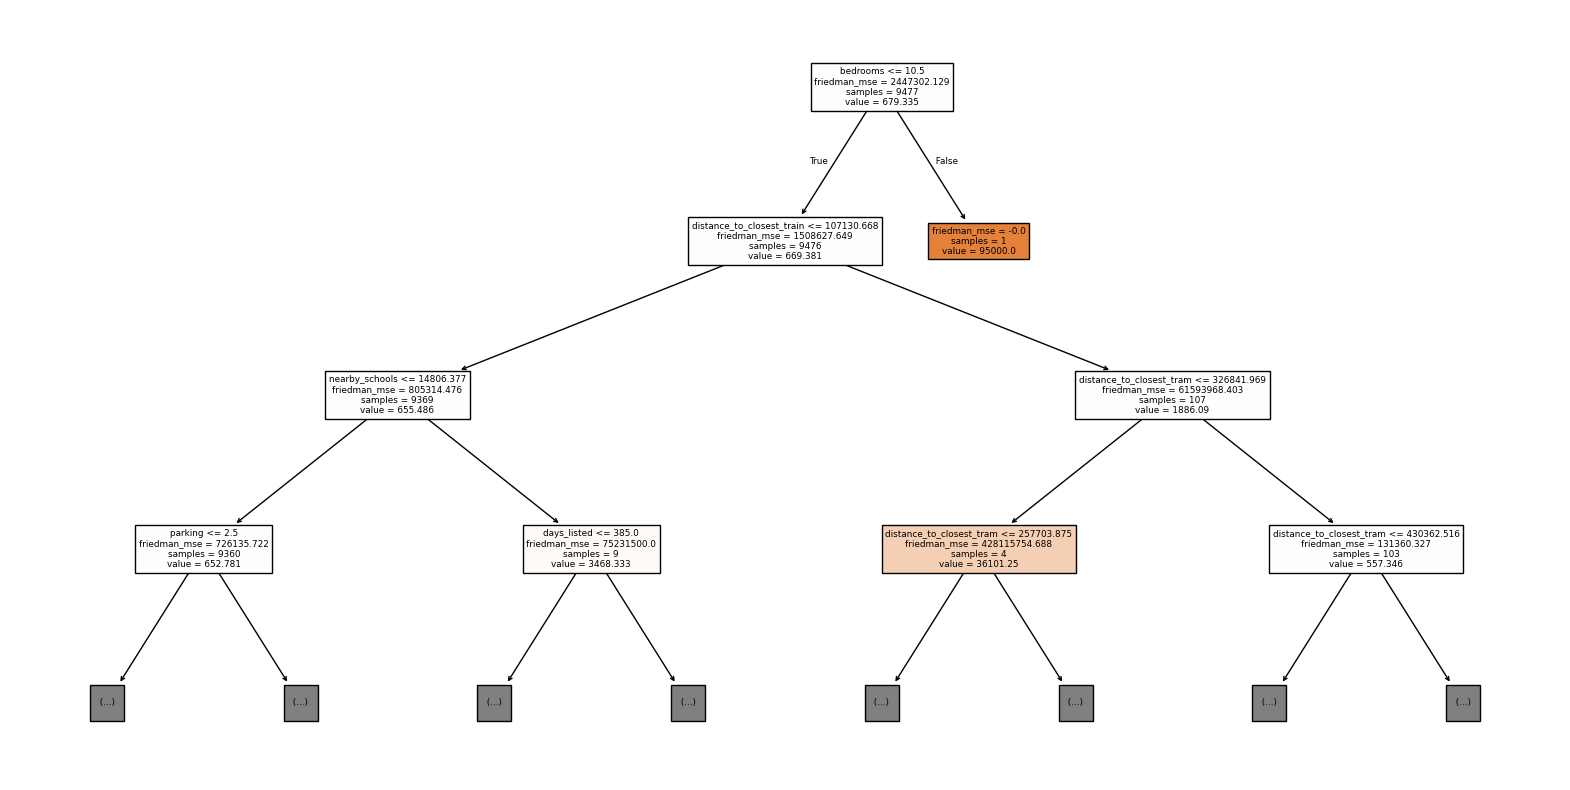

In [14]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the first tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=feature_list, filled=True, max_depth=3)
plt.show()